In [0]:
#add tfidf for keyword sample

In [1]:
!git clone https://github.com/zxzhaixiang/QMDB

Cloning into 'QMDB'...
remote: Enumerating objects: 584, done.
remote: Total 584 (delta 0), reused 0 (delta 0), pack-reused 584
Receiving objects: 100% (584/584), 266.80 MiB | 37.76 MiB/s, done.
Resolving deltas: 100% (328/328), done.
Checking out files: 100% (101/101), done.


In [0]:
datapath = './QMDB/data/processed_data/'
#datapath = './../data/processed_data/'

In [3]:
!pip install hiddenlayer

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
savepath = './gdrive/My Drive/'

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import pickle
import random
import scipy.signal as sp_signal
import pandas as pd
import seaborn as sns
from datetime import datetime
import re

from imblearn.over_sampling import RandomOverSampler

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

from sklearn.manifold import TSNE
import scipy.stats

from IPython.display import HTML, display

import hiddenlayer as hl
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler
from torch.autograd import Variable
from torchvision import transforms

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ", device)

Device is  cuda


In [9]:
torch.__version__

'1.1.0'

## Loading data and prepare data loader

In [10]:
print('loading raw rating data..',end='')
rating_df = pd.read_csv(os.path.join(datapath,'ratings_with_kws.csv'), compression='gzip')

#print('Done\n {} total rating record loaded\n'.format(rating_df.shape[0]))

userIds = rating_df['userId'].unique()

loading raw rating data..

In [0]:
user_df = rating_df.groupby('userId', as_index=False).agg({
                      'movieId': [('num_movie_rated','count')],
                      'rating': [('user_ave_rating','mean'),('user_std_rating','std')]}).fillna(0)
user_df.columns.set_levels([item if item!='' else 'userId' for item in user_df.columns.levels[1]],level=1,inplace=True)
user_df.columns = user_df.columns.droplevel(0) #drop first level column name (old column name before aggregation)

In [0]:
rating_by_movie_df = rating_df.groupby('movieId', as_index = False).agg({
                    'userId': [('num_rating', 'count')],
                    'rating': [('movie_ave_rating','mean'),('movie_std_rating', 'std')]})
rating_by_movie_df.columns.set_levels([item if item!='' else 'movieId' for item in rating_by_movie_df.columns.levels[1]],level=1,inplace=True)
rating_by_movie_df.columns = rating_by_movie_df.columns.droplevel(0)#drop first level column name (old column name before aggregation)       

In [0]:
movie_df = pd.read_csv(os.path.join(datapath,'keywords_all.csv'))
movie_df = movie_df.merge(rating_by_movie_df, how='left',on='movieId').reset_index()
#movie_df.drop(columns='genres',inplace=True)
movie_df['genre_kws'] = movie_df['genre_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s).lower()) 
#movie_df['description_kws'] = movie_df['description_kws'].apply(lambda s: re.sub(r'\[|\]|\'| |"', '', s).lower()) 
#movie_df['cast_kws'] = movie_df['cast_kws'].apply(lambda s: re.sub(r'\[|\]|\'| ', '', s)) 

#genres = {a for s in movie_df['genres'] for a in s.split('|')}
#print('{} number of movie genres exist. They are '.format(len(genres)), genres)
#genres_dict = dict(zip(genres, range(len(genres))))

In [14]:
#genres_list = {a.lower() for s in movie_df['genre_kws'] for a in s.split(',')}
#genres_list = list(genres_list)
genres_list = ['tv', 'movie', 'fantasy', 'documentary', 'comedy', 'drama', 'mystery', 'horror', 'science', 'family', 'crime', 'history', 'action', 'adventure', 'fiction', 'music', 'war', 'animation', 'western', 'thriller', 'foreign', 'romance']
print('{} number of movie genres exist. They are '.format(len(genres_list)), genres_list)
genres_dict = dict(zip(genres_list, range(len(genres_list))))

22 number of movie genres exist. They are  ['tv', 'movie', 'fantasy', 'documentary', 'comedy', 'drama', 'mystery', 'horror', 'science', 'family', 'crime', 'history', 'action', 'adventure', 'fiction', 'music', 'war', 'animation', 'western', 'thriller', 'foreign', 'romance']


In [0]:
genres = np.zeros((movie_df.shape[0], len(genres_list)))
for irow, s in enumerate(movie_df['genre_kws']):
    for j in [genres_dict[e] for e in s.split(',')]:
        genres[irow,j]=1

### keywords

In [0]:
with open(os.path.join(datapath,'keyword_embedding.pkl'), 'rb') as f:
    kw_embedding_np = pickle.load(f)

In [0]:
kw_embedding = dict()
kw_default_embedding = torch.zeros(1,1,64)
n=0
for key in kw_embedding_np:
    kw_embedding[key] = torch.FloatTensor(kw_embedding_np[key]).unsqueeze(dim=0).unsqueeze(dim=0)
    kw_default_embedding += kw_embedding[key]
    n+=1

kw_default_embedding/=n

In [0]:
kw_set = set(kw_embedding.keys())

In [19]:
len(kw_set)

21403

In [0]:
corpus  = [kws for kws in movie_df['kws_all']]
vectorizer = TfidfVectorizer(max_df=0.1, min_df=0.0003)
X = vectorizer.fit_transform(corpus)

In [0]:
words = vectorizer.get_feature_names()
Tfidf_indmap = dict(zip(words, range(len(words))))

In [0]:
kw_by_movie = [[words[j] for j in X_row.nonzero()[1]] for X_row in X]
kw_relevance_by_movie = [np.array([float(X_row[0,j]) for j in X_row.nonzero()[1]]) for X_row in X]
kw_relevance_by_movie = [r/r.sum() for r in kw_relevance_by_movie]

In [0]:
movie_default_kw_embedding_np = np.array([np.average(np.stack([kw_embedding_np[kw] for kw in kws], axis=0),axis=0, weights = kw_imps) for kws, kw_imps in zip(kw_by_movie,kw_relevance_by_movie)])
movie_default_kw_embedding = torch.FloatTensor(movie_default_kw_embedding_np)

In [25]:
TopMovies_id = movie_df['num_rating'].nlargest(200).index.values
Movie_Em = movie_default_kw_embedding_np/np.linalg.norm(movie_default_kw_embedding_np,axis=1, keepdims=True)
Movie_S = np.matmul(Movie_Em, Movie_Em.T)
for i in range(50):
    movie_id = TopMovies_id[i]
    t = movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(movie_df['movie_ave_rating'][tmp_id]>0.0):
            t = movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Matrix Revolutions, The
   Matrix Reloaded, The
   Blade Runner
   Star Wars: Episode IV - A New Hope
   Akira
   Moon
   Terminator 2: Judgment Day
   Dark City
   Pan's Labyrinth (Laberinto del fauno, El)
   Ex Machina
   Tron: Legacy

Movie:Forrest Gump
   Inside Out
   Up
   Little Miss Sunshine
   Curious Case of Benjamin Button, The
   Schindler's List
   Donnie Darko
   Shawshank Redemption, The
   Away We Go
   Never Let Me Go
   World's Greatest Dad
   Slumdog Millionaire

Movie:Back to the Future
   The Lego Movie
   Big Hero 6
   Wreck-It Ralph
   Toy Story
   Up
   Close Encounters of the Third Kind
   Inception
   E.T. the Extra-Terrestrial
   WALL·E
   Station Agent, The
   Diary of a Wimpy Kid

Movie:Pulp Fiction
   Reservoir Dogs
   Fight Club
   Kick-Ass
   Fifth Element, The
   Memento
   Looper
   Her
   Sin City
   Donnie Darko
   Slumdog Millionaire
   Usual Suspects, The

Movie:Jurassic Park
   Monsters
   Land of the Lost
   Jurassic World
  

### prepare data

In [0]:
nM      = movie_df.shape[0]
nU      = user_df.shape[0]
nR      = rating_df['rating'].unique().shape[0]
nRecord = rating_df['rating'].shape[0]

In [0]:
U    = torch.tensor(rating_df['userId'].values,  dtype=torch.long).reshape(-1,1)
M    = torch.tensor(rating_df['qmdbId'].values, dtype=torch.long).reshape(-1,1)
R    = torch.tensor(rating_df['rating'].values, dtype=torch.float).reshape(-1,1)/5
G    = torch.tensor(genres, dtype=torch.float)
Qkw  = movie_default_kw_embedding

In [0]:
batch_size = 4096
validation_split = .2
shuffle_dataset = True
random_seed = 42

In [0]:
dataset_size = nRecord
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_idx, val_idx = indices[split:], indices[:split]

In [0]:
ros = RandomOverSampler(random_state=random_seed)
train_idx_resampled, _ = ros.fit_resample(np.array(train_idx).reshape(-1,1), (R[train_idx].numpy()*10).reshape(-1).astype(int))
train_idx_resampled = list(train_idx_resampled.reshape(-1))

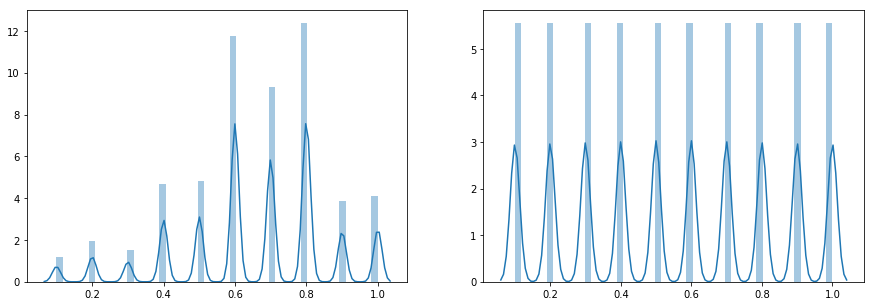

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(121)
sns.distplot(R[train_idx])
plt.subplot(122)
sns.distplot(R[train_idx_resampled])

In [0]:
ind = train_idx
#ind = train_idx_resampled

train_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle = True)

In [0]:
ind = val_idx
val_dataset = torch.utils.data.TensorDataset(
    U[ind], M[ind], R[ind])
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle = True)

## Build model

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
class NCF(nn.Module):
    def __init__(self, config):
        super(NCF, self).__init__()
        self.config = config
        self.user_dim = config['nUsers']
        self.movie_dim = config['nMovies']
        self.genres_dim = config['nGenres']
        
        self.g_latent_dim = config['genre_latent_dim']
        self.u_latent_dim = config['user_latent_dim']
        self.i_latent_dim = config['item_latent_dim']
        
        self.user_embedding = nn.Embedding(self.user_dim, self.u_latent_dim, 
                                           max_norm=1, scale_grad_by_freq = True)
        
        self.movie_embedding = nn.Embedding(self.movie_dim, self.i_latent_dim,
                                           max_norm=1, scale_grad_by_freq = True)

        self.genres_layers = nn.Sequential(
                                nn.Linear(self.genres_dim, self.g_latent_dim)
        )
        
        self.fc_layers_relevance = nn.Sequential(
            nn.Linear(self.g_latent_dim + self.i_latent_dim + 64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        self.cos_sim = nn.CosineSimilarity(dim=2, eps=1e-6)
        
    def forward(self, user_id, movie_id, genres, em_query):
        user_em = self.user_embedding(user_id)
        movie_em = self.movie_embedding(movie_id)
        genres_em = self.genres_layers(genres)
        
        final_query_em = user_em + genres_em + em_query
        
        relevance_em = torch.cat((movie_em, genres_em, em_query), dim=2)
        relevance_em = relevance_em.view(-1,self.g_latent_dim + self.i_latent_dim + 64)

        relevance_score = self.fc_layers_relevance(relevance_em)

        return relevance_score.view(-1,1), torch.bmm(final_query_em, movie_em.view(-1,self.i_latent_dim, 1)).view(-1,1)

In [37]:
config = {'nUsers': nU, 'nMovies': nM, 
          'nGenres': len(genres_list),
          'user_latent_dim': 64, 'item_latent_dim': 64,
          'genre_latent_dim': 64
         }
print(config)


{'nUsers': 4380, 'nMovies': 3868, 'nGenres': 22, 'user_latent_dim': 64, 'item_latent_dim': 64, 'genre_latent_dim': 64}


In [0]:
CF = NCF(config).to(device)

In [0]:
CF_criterion = nn.MSELoss()
CF_relevance_criterion = nn.BCELoss()

CF_optimizer = torch.optim.Adam(CF.parameters(), lr = 0.001, betas = (0.5, 0.999))

In [40]:
count_parameters(CF)

545921

/usr/local/lib/python3.6/dist-packages/torch/onnx/utils.py:586: UserWarning: ONNX export failed on ATen operator embedding_renorm because torch.onnx.symbolic.embedding_renorm does not exist
  .format(op_name, op_name))


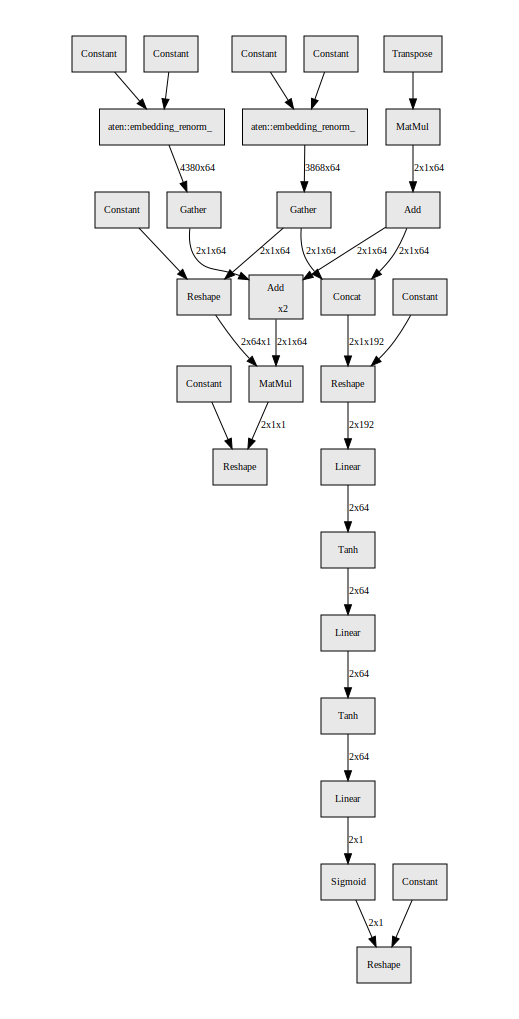

In [41]:
hl.build_graph(CF, (torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   )) #hr


In [42]:
CF(torch.LongTensor(np.zeros((2,1))).to(device), #uids
   torch.LongTensor(np.zeros((2,1))).to(device), #mids
   torch.FloatTensor(np.zeros((2,1,len(genres_list)))).to(device), #gids
   torch.FloatTensor(np.zeros((2,1,64))).to(device)#query
   ) #hr


(tensor([[0.5181],
         [0.5181]], device='cuda:0', grad_fn=<ViewBackward>), tensor([[0.0577],
         [0.0577]], device='cuda:0', grad_fn=<ViewBackward>))

## Training

In [0]:
class progress():
    def __init__(self,max = 100):
        self.mrange = max
        self.pbar = display(self.progress(0,M=self.mrange, loss_score=0, loss_relevance=0), display_id = True)

    def update(self, i, loss_score=0, loss_relevance=0):
        self.pbar.update(self.progress(i,M=self.mrange, loss_score=loss_score, loss_relevance=loss_relevance))
    
    def progress(self, value, loss_score=0, loss_relevance=0, M=100):
        return HTML("""Training Mini Batch [{value}/{M}] Loss [rating={loss_score:0.5f}, relevance={loss_relevance:0.5f}] <progress
                value='{value}'
                max='{M}',
                style='width: 80%'
            >
                90
            </progress>
              """.format(value=value, M=M, loss_score=loss_score, loss_relevance=loss_relevance))

In [44]:
nBatch_train = train_loader.__len__()
nBatch_val = val_loader.__len__()

print('{} mini-batches in training dataset, {} mini-batches in validation dataset'.format(nBatch_train, nBatch_val))

657 mini-batches in training dataset, 165 mini-batches in validation dataset


In [0]:
epoch_num = 50

In [0]:
def lr_schedular(optimizer, epoch):
    if(epoch<2):
        lr = 0.001
    elif(epoch<10):
        lr = 0.0006
    elif (epoch<20):
        lr = 0.0004
    else:
        lr = 0.0002

    for param_group in optimizer.param_groups:
        param_group['lr']=lr

    return optimizer

In [0]:
G = G.to(device)

In [0]:
def get_irrelevant_movies(movies):
    res = np.random.choice(nM, movies.shape[0], replace=True)
    return torch.LongTensor(res).view(movies.shape)

In [0]:
def get_query_tensor(movieIds):
    
    def get_embedding(kw_list):
        if len(kw_list)==0:
            return kw_default_embedding
        else:
            res = torch.zeros(kw_default_embedding.shape)
            for kw in kw_list:
#                if kw in kw_set:
                res+=kw_embedding[kw]
            return res/len(kw_list)

    res = []
    for i in movieIds.detach().cpu().numpy().flatten():
        n_kw = len(kw_by_movie[i])
        kws = random.choices(kw_by_movie[i], weights = kw_relevance_by_movie[i], k = random.randint(5,15))
        res.append(get_embedding(kws))

    return torch.cat(res,dim=0).to(device)

In [0]:
train_losses = []
train_rating_losses = []
train_relevance_losses = []

val_losses = []
val_rating_losses = []
val_relevance_losses = []

In [0]:
#(CF.genres_layers(G[movies])/(1+G[movies].sum(dim=2, keepdim=True))).shape

Training epoch 0/50


epoch[0/50], train loss = 2.865=10x0.042(rating) + 2.443(relevance), val loss = 2.972=10x0.049(rating)+2.484(relevance)


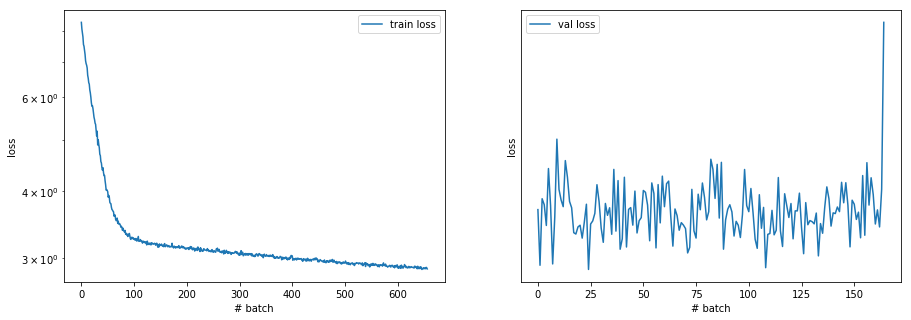

Training epoch 1/50


epoch[1/50], train loss = 2.561=10x0.029(rating) + 2.270(relevance), val loss = 2.588=10x0.033(rating)+2.256(relevance)


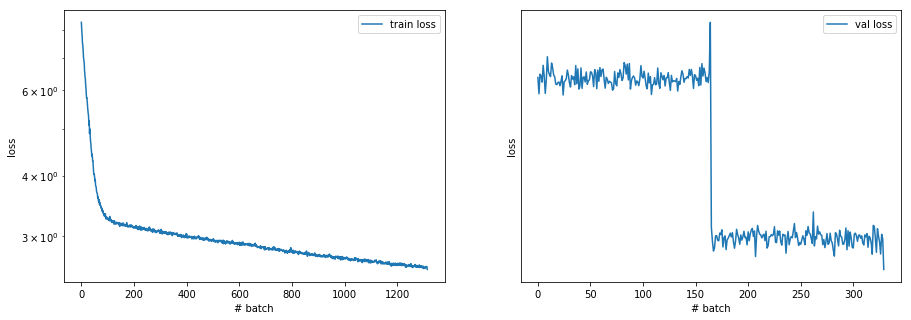

Training epoch 2/50


epoch[2/50], train loss = 2.429=10x0.023(rating) + 2.198(relevance), val loss = 2.461=10x0.030(rating)+2.161(relevance)


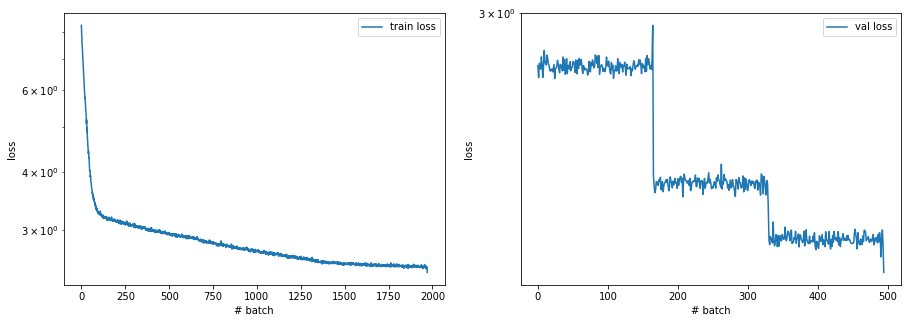

Training epoch 3/50


epoch[3/50], train loss = 2.463=10x0.032(rating) + 2.142(relevance), val loss = 2.439=10x0.032(rating)+2.115(relevance)


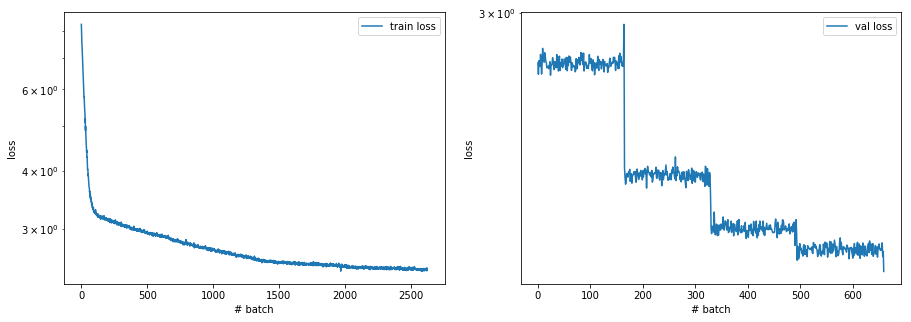

Training epoch 4/50


epoch[4/50], train loss = 2.433=10x0.027(rating) + 2.165(relevance), val loss = 2.431=10x0.029(rating)+2.143(relevance)


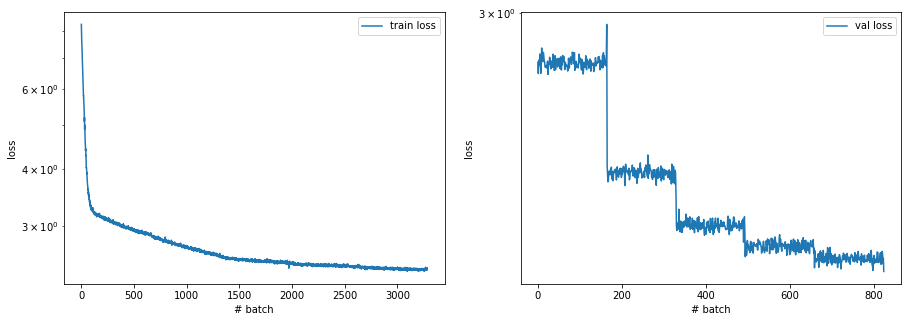

Training epoch 5/50


epoch[5/50], train loss = 2.376=10x0.027(rating) + 2.106(relevance), val loss = 2.325=10x0.027(rating)+2.058(relevance)


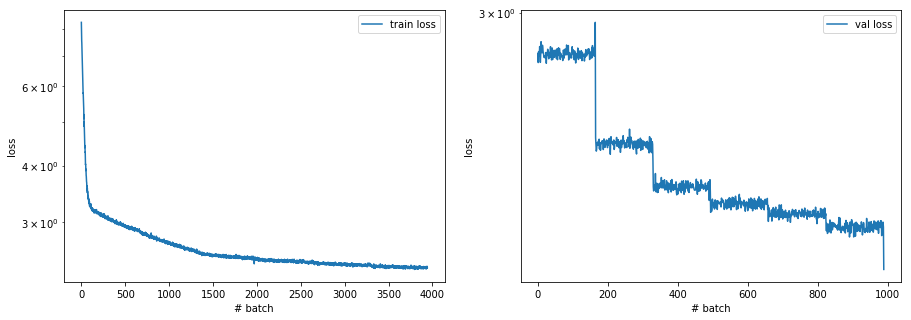

Training epoch 6/50


epoch[6/50], train loss = 2.378=10x0.027(rating) + 2.105(relevance), val loss = 2.259=10x0.020(rating)+2.056(relevance)


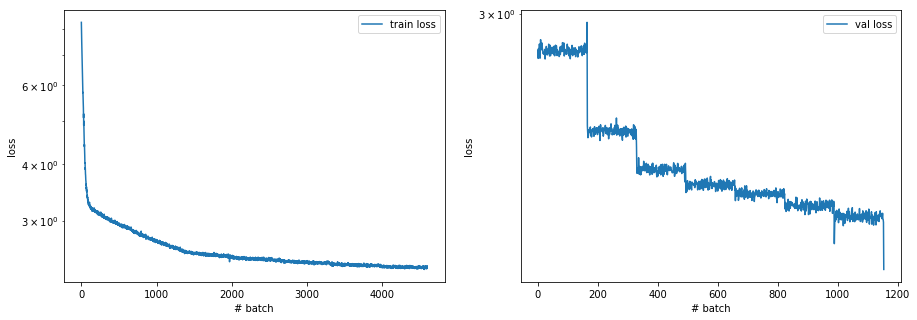

Training epoch 7/50


epoch[7/50], train loss = 2.334=10x0.025(rating) + 2.086(relevance), val loss = 2.401=10x0.030(rating)+2.101(relevance)


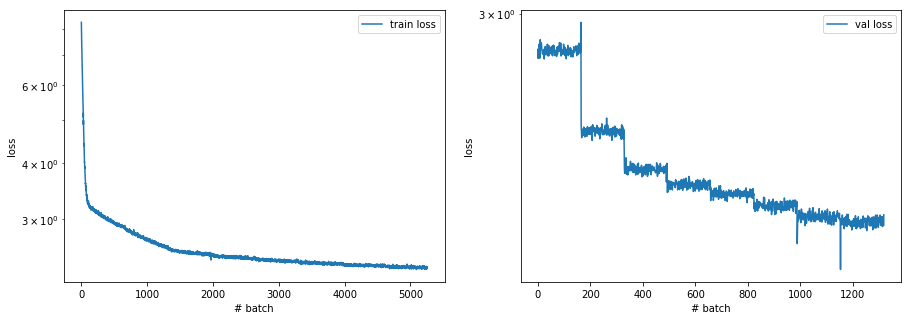

Training epoch 8/50


epoch[8/50], train loss = 2.314=10x0.022(rating) + 2.090(relevance), val loss = 2.317=10x0.020(rating)+2.118(relevance)


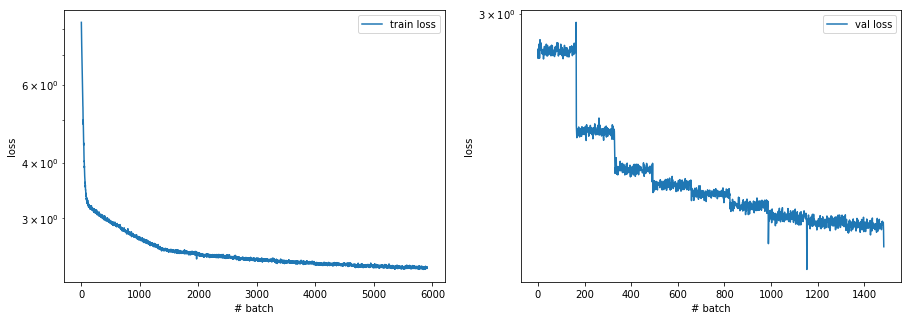

Training epoch 9/50


epoch[9/50], train loss = 2.284=10x0.022(rating) + 2.064(relevance), val loss = 2.258=10x0.020(rating)+2.061(relevance)


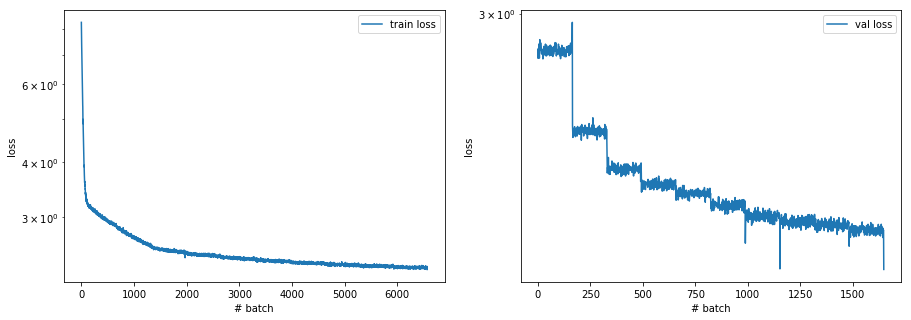

Training epoch 10/50


epoch[10/50], train loss = 2.272=10x0.021(rating) + 2.059(relevance), val loss = 2.302=10x0.027(rating)+2.028(relevance)


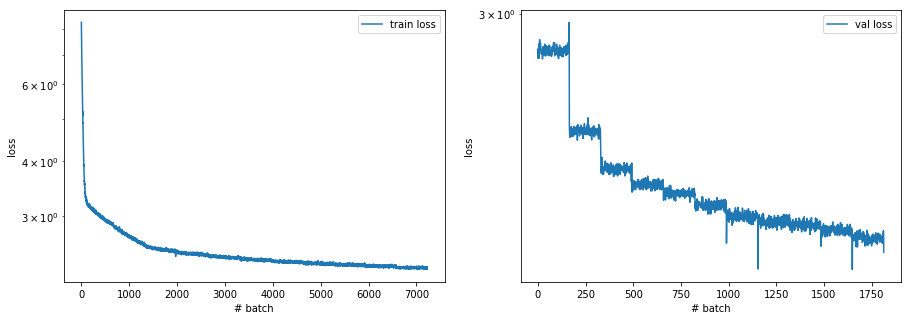

Training epoch 11/50


epoch[11/50], train loss = 2.293=10x0.024(rating) + 2.049(relevance), val loss = 2.468=10x0.034(rating)+2.126(relevance)


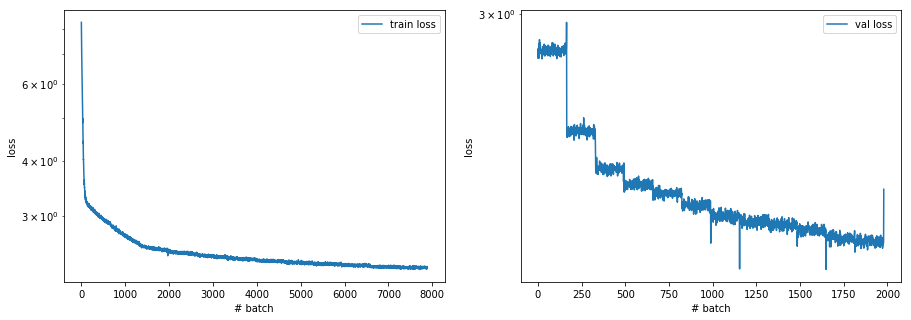

Training epoch 12/50


epoch[12/50], train loss = 2.260=10x0.021(rating) + 2.049(relevance), val loss = 2.349=10x0.027(rating)+2.079(relevance)


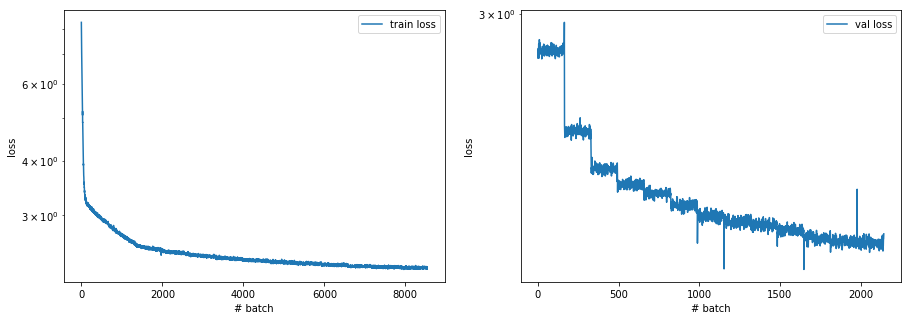

Training epoch 13/50


epoch[13/50], train loss = 2.310=10x0.025(rating) + 2.064(relevance), val loss = 2.350=10x0.020(rating)+2.147(relevance)


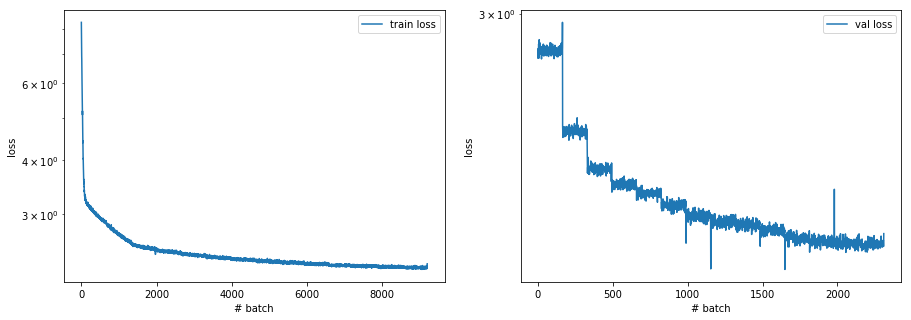

Training epoch 14/50


epoch[14/50], train loss = 2.266=10x0.020(rating) + 2.062(relevance), val loss = 2.372=10x0.030(rating)+2.077(relevance)


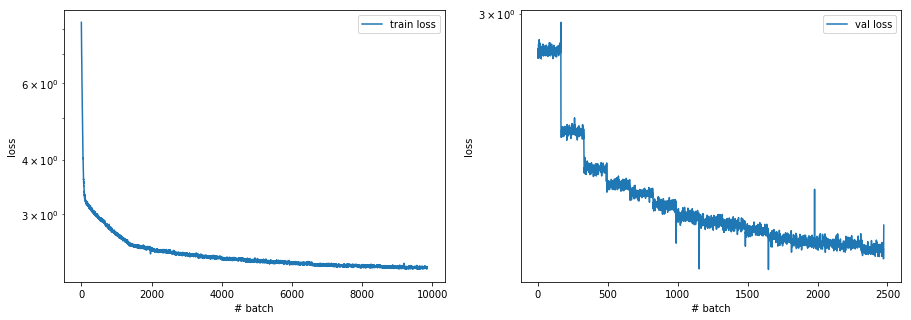

Training epoch 15/50


epoch[15/50], train loss = 2.226=10x0.023(rating) + 1.994(relevance), val loss = 2.286=10x0.028(rating)+2.008(relevance)


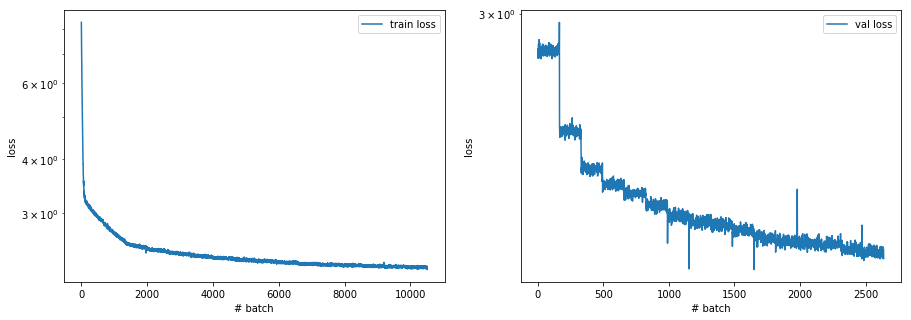

Training epoch 16/50


epoch[16/50], train loss = 2.293=10x0.022(rating) + 2.068(relevance), val loss = 2.320=10x0.028(rating)+2.040(relevance)


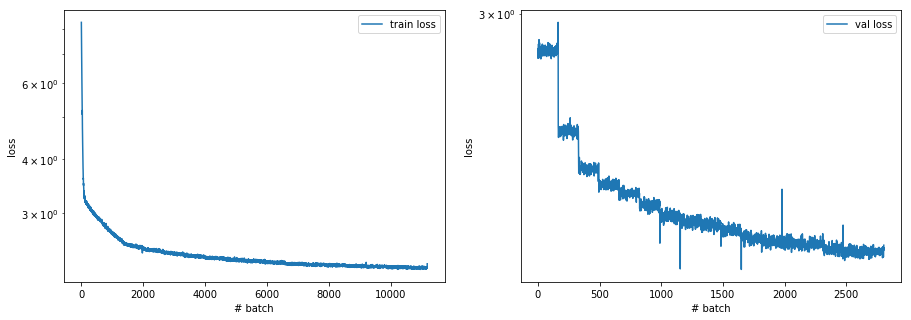

Training epoch 17/50


epoch[17/50], train loss = 2.272=10x0.022(rating) + 2.053(relevance), val loss = 2.265=10x0.022(rating)+2.040(relevance)


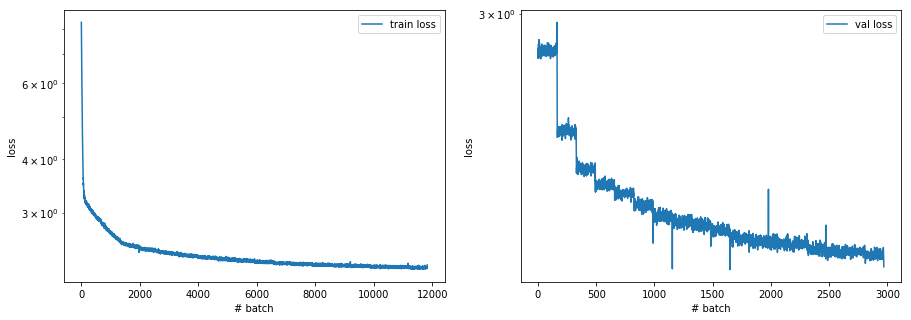

Training epoch 18/50


epoch[18/50], train loss = 2.213=10x0.020(rating) + 2.011(relevance), val loss = 2.383=10x0.027(rating)+2.109(relevance)


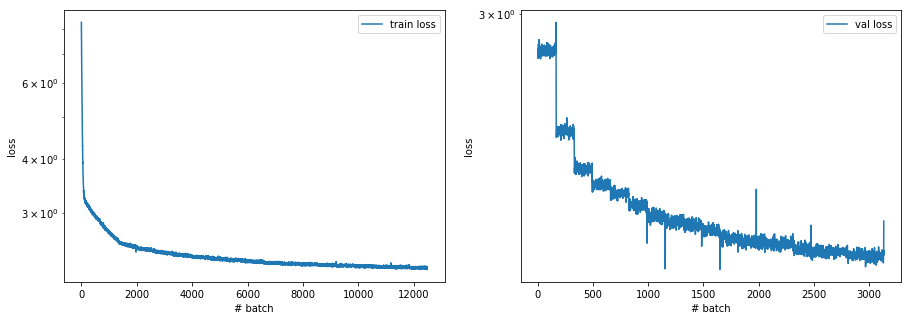

Training epoch 19/50


epoch[19/50], train loss = 2.228=10x0.019(rating) + 2.042(relevance), val loss = 2.300=10x0.027(rating)+2.027(relevance)


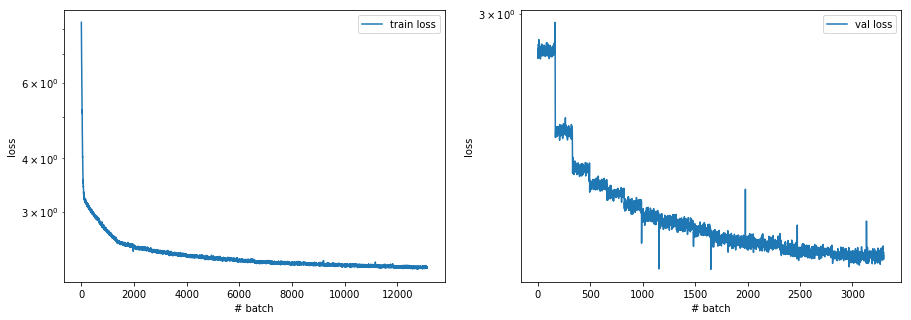

Training epoch 20/50


epoch[20/50], train loss = 2.195=10x0.019(rating) + 2.003(relevance), val loss = 2.350=10x0.034(rating)+2.005(relevance)


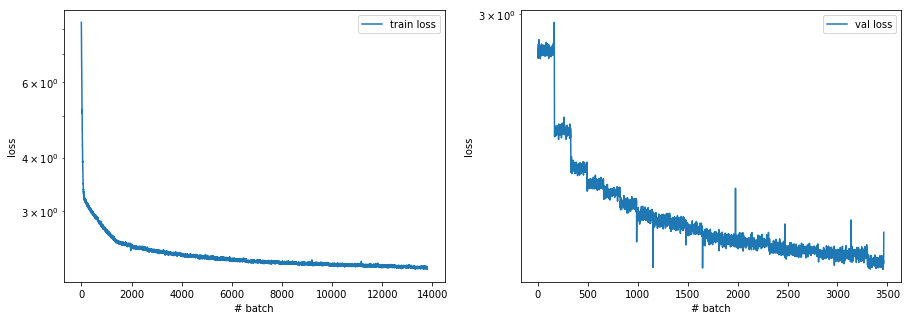

Training epoch 21/50


epoch[21/50], train loss = 2.220=10x0.020(rating) + 2.022(relevance), val loss = 2.193=10x0.020(rating)+1.996(relevance)


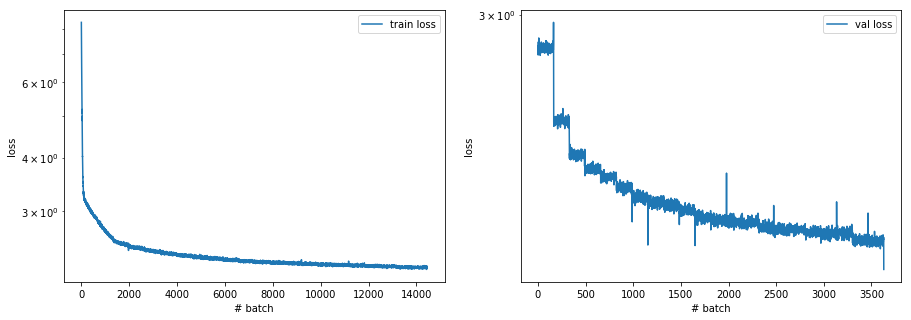

Training epoch 22/50


epoch[22/50], train loss = 2.180=10x0.018(rating) + 1.999(relevance), val loss = 2.249=10x0.029(rating)+1.963(relevance)


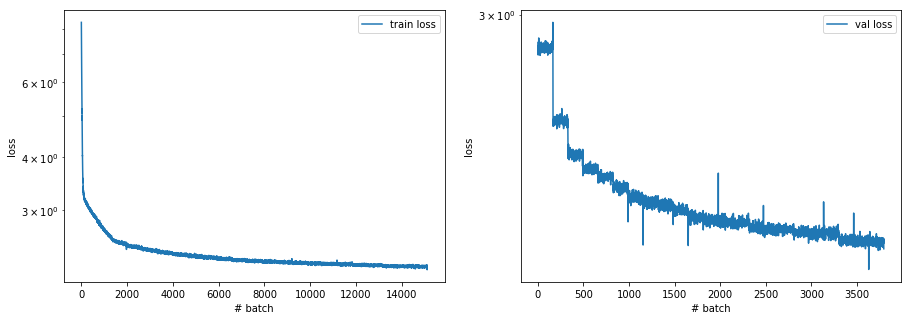

Training epoch 23/50


epoch[23/50], train loss = 2.196=10x0.017(rating) + 2.026(relevance), val loss = 2.261=10x0.023(rating)+2.034(relevance)


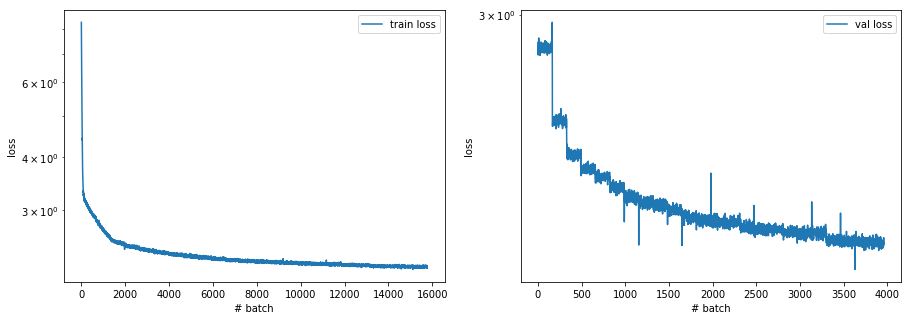

Training epoch 24/50


epoch[24/50], train loss = 2.204=10x0.018(rating) + 2.024(relevance), val loss = 2.332=10x0.028(rating)+2.052(relevance)


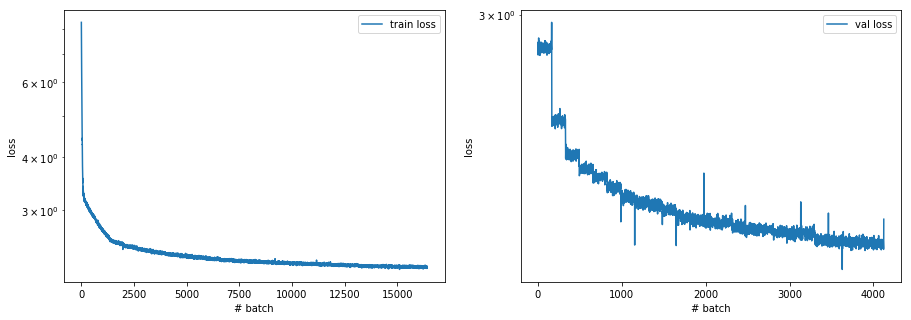

Training epoch 25/50


epoch[25/50], train loss = 2.200=10x0.022(rating) + 1.983(relevance), val loss = 2.321=10x0.027(rating)+2.049(relevance)


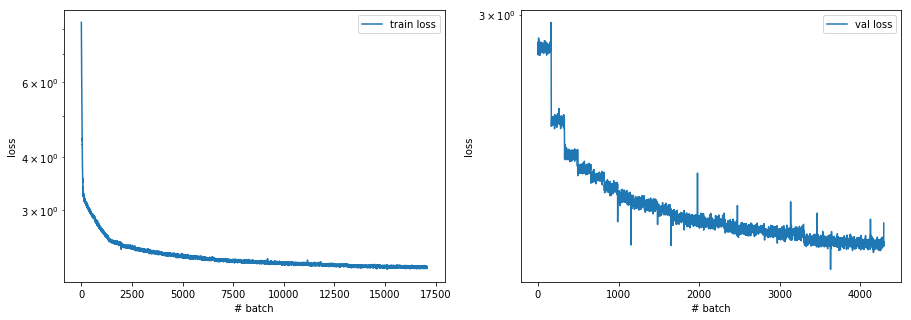

Training epoch 26/50


epoch[26/50], train loss = 2.193=10x0.020(rating) + 1.991(relevance), val loss = 2.292=10x0.025(rating)+2.045(relevance)


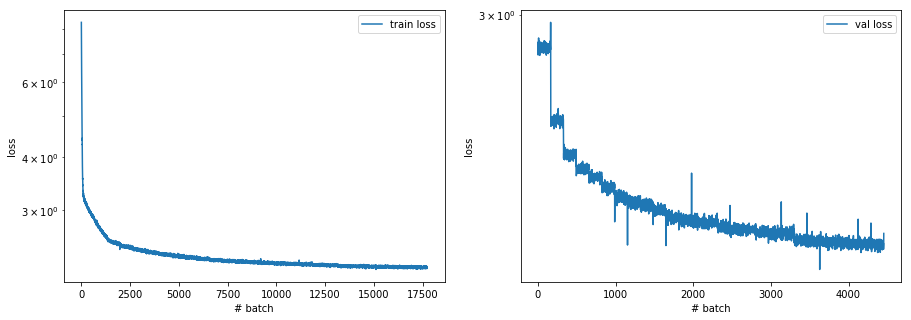

Training epoch 27/50


epoch[27/50], train loss = 2.178=10x0.020(rating) + 1.981(relevance), val loss = 2.181=10x0.023(rating)+1.955(relevance)


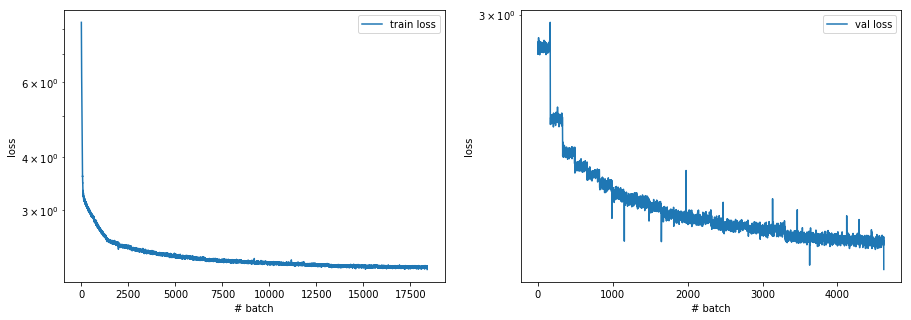

Training epoch 28/50


epoch[28/50], train loss = 2.215=10x0.021(rating) + 2.009(relevance), val loss = 2.293=10x0.024(rating)+2.051(relevance)


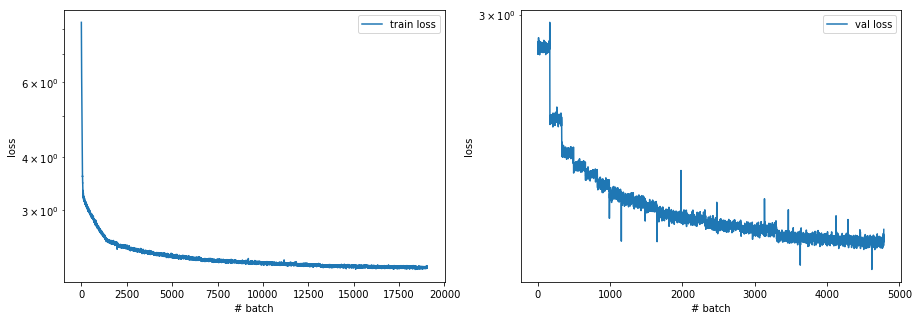

Training epoch 29/50


epoch[29/50], train loss = 2.237=10x0.025(rating) + 1.990(relevance), val loss = 2.252=10x0.028(rating)+1.975(relevance)


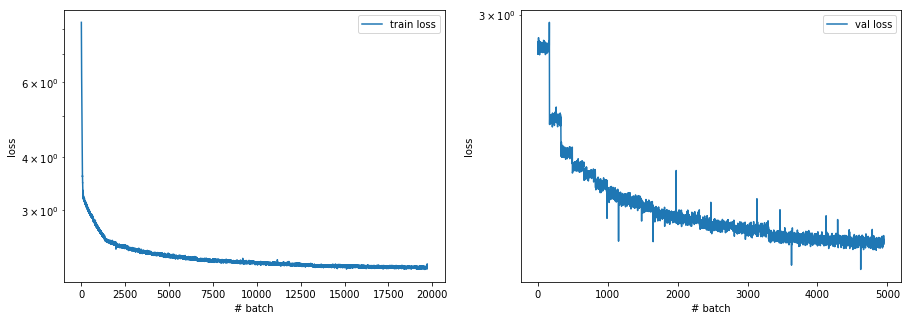

Training epoch 30/50


epoch[30/50], train loss = 2.231=10x0.022(rating) + 2.013(relevance), val loss = 2.260=10x0.026(rating)+2.001(relevance)


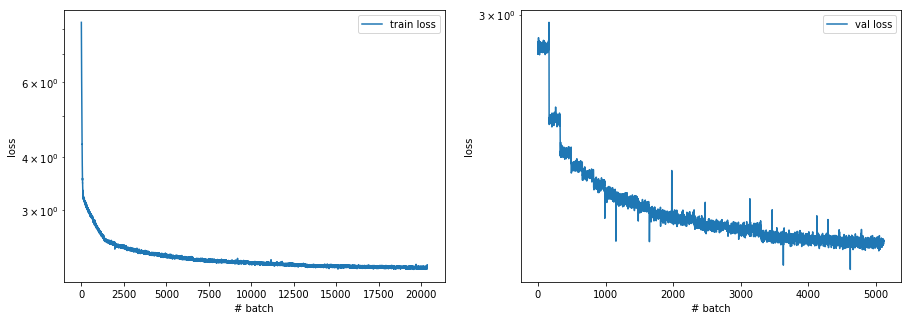

Training epoch 31/50


epoch[31/50], train loss = 2.188=10x0.020(rating) + 1.989(relevance), val loss = 2.251=10x0.026(rating)+1.989(relevance)


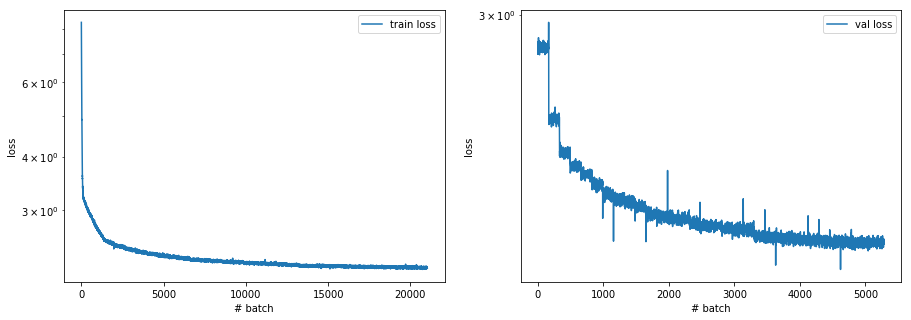

Training epoch 32/50


epoch[32/50], train loss = 2.187=10x0.018(rating) + 2.009(relevance), val loss = 2.363=10x0.034(rating)+2.024(relevance)


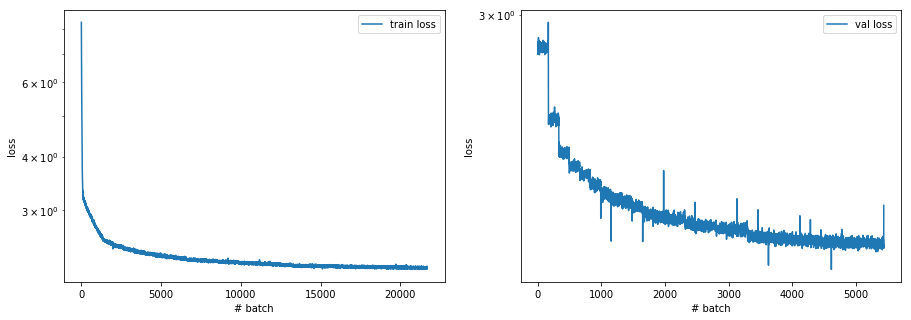

Training epoch 33/50


epoch[33/50], train loss = 2.189=10x0.018(rating) + 2.012(relevance), val loss = 2.142=10x0.018(rating)+1.958(relevance)


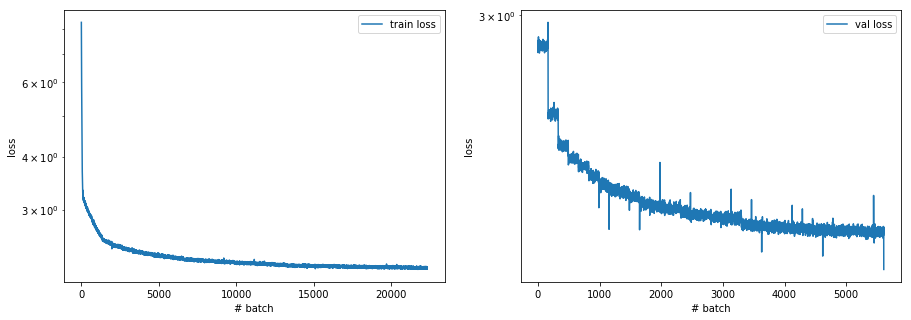

Training epoch 34/50


KeyboardInterrupt: ignored

In [113]:
for epoch in range(epoch_num):
    
    print('Training epoch {}/{}'.format(epoch, epoch_num))
    pbar = progress(train_loader.__len__())
    
    CF_optimizer = lr_schedular(CF_optimizer, epoch)

    CF.train()
    
    tmp_loss_rating = 0
    tmp_loss_relevance = 0
    
    for i,(users, movies, ratings) in enumerate(train_loader):
        if i%5==0:
            pbar.update(i+1, tmp_loss_rating, tmp_loss_relevance)

        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        irrelevant_movies = get_irrelevant_movies(movies)
        #Q = get_query_tensor(movies)
        #Q_irrelevant = get_query_tensor(irrelevant_movie)
        Q = get_query_tensor(movies)
        Q_irrelevant = get_query_tensor(irrelevant_movies)

        rel_score, rhat = CF(U, I, G[movies], Q)
        irrel_score_TF, _ = CF(U, I, G[movies], Q_irrelevant)
        irrel_score_FT, _ = CF(U, I, G[irrelevant_movies], Q)
        irrel_score_FF, _ = CF(U, I, G[irrelevant_movies], Q_irrelevant)

        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(irrel_score_FF, 0.1*torch.ones(rel_score.shape).to(device)) + \
                        CF_relevance_criterion(irrel_score_TF, 0.2*torch.ones(rel_score.shape).to(device)) + \
                        CF_relevance_criterion(irrel_score_FT, 0.3*torch.ones(rel_score.shape).to(device)) + \
                        CF_relevance_criterion(rel_score, 0.9*torch.ones(rel_score.shape).to(device))
                         
        loss = 10*loss_rating + loss_relevance
        
        CF_optimizer.zero_grad()
        
        loss.backward()
        
        CF_optimizer.step()
        
        train_losses.append(loss.item())
        train_rating_losses.append(loss_rating.item())
        train_relevance_losses.append(loss_relevance.item())
        
        tmp_loss_rating = loss_rating.item()
        tmp_loss_relevance = loss_relevance.item()        
    
    CF.eval()

    torch.save(CF.state_dict(), os.path.join(savepath,'cfmodel_v04'))
    torch.save(CF.state_dict(), os.path.join('./cfmodel_v04'))

    for i, (users, movies, ratings) in enumerate(val_loader):
        U, I, R = users.to(device), movies.to(device), ratings.to(device)
        irrelevant_movies = get_irrelevant_movies(movies)
        Q = get_query_tensor(movies)
        Q_irrelevant = get_query_tensor(irrelevant_movies)

        rel_score, rhat = CF(U, I, G[movies], Q)
        irrel_score_TF, _ = CF(U, I, G[movies], Q_irrelevant)
        irrel_score_FT, _ = CF(U, I, G[irrelevant_movies], Q)
        irrel_score_FF, _ = CF(U, I, G[irrelevant_movies], Q_irrelevant)

        loss_rating = CF_criterion(rhat, R)
        
        loss_relevance = CF_relevance_criterion(irrel_score_FF, 0.1*torch.ones(rel_score.shape).to(device)) + \
                        CF_relevance_criterion(irrel_score_TF, 0.2*torch.ones(rel_score.shape).to(device)) + \
                        CF_relevance_criterion(irrel_score_FT, 0.3*torch.ones(rel_score.shape).to(device)) + \
                        CF_relevance_criterion(rel_score, 0.9*torch.ones(rel_score.shape).to(device))
                         
        loss = 10*loss_rating + loss_relevance
        
        val_losses.append(loss.item())
        val_rating_losses.append(loss_rating.item())
        val_relevance_losses.append(loss_relevance.item())
    
    print('epoch[{}/{}], train loss = {:.3f}=10x{:.3f}(rating) + {:.3f}(relevance), val loss = {:.3f}=10x{:.3f}(rating)+{:.3f}(relevance)'.
         format(epoch, epoch_num, train_losses[-1], train_rating_losses[-1], train_relevance_losses[-1], val_losses[-1], val_rating_losses[-1], val_relevance_losses[-1]))
    
    if (epoch%1==0):
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.plot(train_losses, label='train loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.subplot(122)
        plt.plot(val_losses, label='val loss')
        plt.xlabel('# batch'), plt.ylabel('loss'), plt.legend(), plt.yscale('log')
        plt.show()

In [0]:
CF.eval()
torch.save(CF.state_dict(), './cfmodel_v04')
torch.save(CF.state_dict(), os.path.join(savepath,'cfmodel_v04'))

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()
User_Em = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
ave_User_Em = User_Em.mean(axis=0, keepdims=True)

In [0]:
with open('./movie_embedding', 'wb') as f:
    pickle.dump(Movie_Em, f)
with open('./ave_user_embedding', 'wb') as f:
    pickle.dump(ave_User_Em, f)


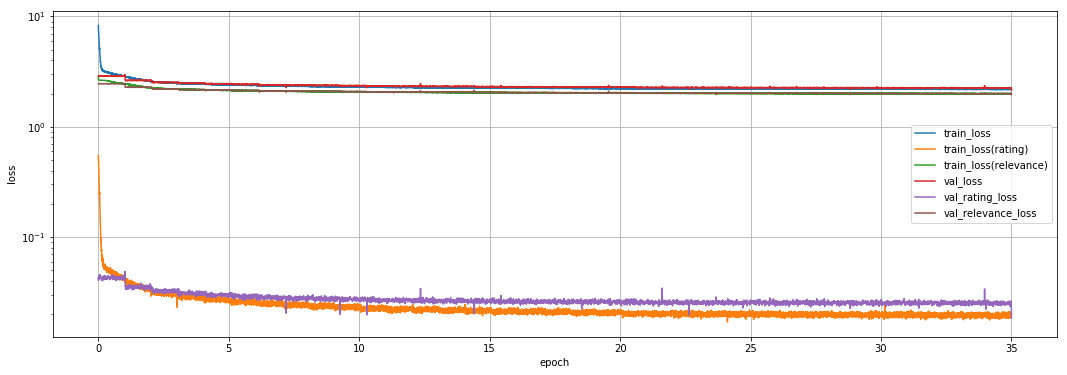

In [118]:
plt.figure(figsize=(18,6))

plt.plot(np.linspace(0,epoch+1, len(train_losses)),train_losses,label='train_loss')
plt.plot(np.linspace(0,epoch+1, len(train_rating_losses)),train_rating_losses,label='train_loss(rating)')
plt.plot(np.linspace(0,epoch+1, len(train_relevance_losses)),train_relevance_losses,label='train_loss(relevance)')
plt.plot(np.linspace(0,epoch+1, len(val_losses)),val_losses,label='val_loss')
plt.plot(np.linspace(0,epoch+1, len(val_rating_losses)),val_rating_losses,label='val_rating_loss')
plt.plot(np.linspace(0,epoch+1, len(val_relevance_losses)),val_relevance_losses,label='val_relevance_loss')
plt.yscale('log')
plt.legend(),plt.xlabel('epoch'), plt.ylabel('loss')
plt.grid(True)
#plt.ylim([0.01,0.05])

In [119]:
r_real = []
r_pred = []

n_tp = 0
n_tn = 0
n_fp = 0
n_fn = 0


with torch.no_grad():
    for i, (u, m,r) in enumerate(val_loader):
        U, I, R = u.to(device), m.to(device), r.to(device)
        irrelevant_movie = get_irrelevant_movies(m)
        Q = Qkw[m.detach().cpu().numpy()].to(device)
        Q_irrelevant = Qkw[irrelevant_movie.detach().cpu().numpy()].to(device)

        rel_score, rhat = CF(U, I, G[m], Q)
        irrel_score, _ = CF(U, I, G[irrelevant_movie], Q_irrelevant)

        r_real+=list(r.detach().cpu().numpy().reshape(-1))
        r_pred+=list(rhat.detach().cpu().numpy().reshape(-1))
        
        rel_score = rel_score.detach().cpu().numpy().flatten()
        irrel_score = irrel_score.detach().cpu().numpy().flatten()
        
        n_tp += np.sum(rel_score>0.5)
        n_tn += np.sum(irrel_score<0.5)
        n_fp += np.sum(irrel_score>0.5)
        n_fn += np.sum(rel_score<0.5)
        
        if(i%20==0):
            print('{}/{}'.format(i,nBatch_val))

0/165
20/165
40/165
60/165
80/165
100/165
120/165
140/165
160/165


In [120]:
print('           | predict relevant  |  predict irrelevant')
print('relevant   |   %5d           |     %5d          ' % (n_tp, n_fn))
print('irrelevant |   %5d           |     %5d          ' % (n_fp, n_tn))

precision = n_tp/(n_tp+n_fp)
recall = n_tp/(n_tp+n_fn)
print('precision = %f' % precision)
print('recall = %f' % recall)

print('F1-score = %f' % (2/(1/precision+1/recall)))

           | predict relevant  |  predict irrelevant
relevant   |   671793           |        21          
irrelevant |    4489           |     667325          
precision = 0.993362
recall = 0.999969
F1-score = 0.996655


In [0]:
r_real = np.array(r_real) #, dtype=np.int)
r_pred = np.array(r_pred) #, dtype=np.int)
e = r_pred - r_real

In [0]:
r_pearson = scipy.stats.pearsonr(r_real, r_pred)[0]
r_spearman = scipy.stats.spearmanr(r_real, r_pred).correlation
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(r_real, r_pred)

In [123]:
print('average error = {}, std = {}'.format(e.mean(), e.std()))
print('mae = {}'.format(np.abs(e).mean()))
print('rmse = {}'.format(np.sqrt(np.square(e).mean())))

print('slope={}, r2={}'.format(slope, r_value))
print('pearson = {}, spearman = {}'.format(r_pearson, r_spearman))

average error = -0.001658098422922194, std = 0.1544862538576126
mae = 0.11761465668678284
rmse = 0.15449514985084534
slope=0.49513047308853414, r2=0.6732776083187093
pearson = 0.6732776083187079, spearman = 0.6578611658204312


(Text(0.5, 0, 'predict error'), Text(0, 0.5, 'count'))

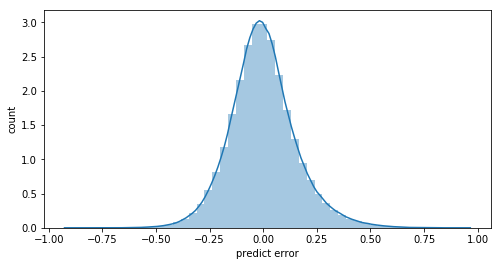

In [124]:
plt.figure(figsize=(8,4))
sns.distplot(r_pred-r_real, kde=True)
plt.xlabel('predict error'), plt.ylabel('count')

In [0]:
real = r.view(-1).detach().cpu().numpy()
pred = rhat.view(-1).detach().cpu().numpy()
users = U.detach().cpu().numpy().reshape(-1)
movies = I.detach().cpu().numpy().reshape(-1)
pd_df = pd.DataFrame({'real': real,'pred':pred, 'userId': users, 'movieId': movies})
pd_df = pd_df.merge(movie_df, how='left', on='movieId')
pd_df = pd_df.merge(user_df, how='left', on='userId')
#pd_df = pd_df.drop(columns = ML_Data.movie_genres)

In [126]:
pd_df.head(50)

,real,pred,userId,movieId,index,Unnamed: 0,title,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating,num_movie_rated,user_ave_rating,user_std_rating
0,0.8,0.814791,95,2263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,754,3.364058,1.049452
1,0.7,0.691590,4082,396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1047,3.612225,0.536046
2,0.3,0.558357,3534,411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,601,3.563228,0.749552
3,0.4,0.573133,3099,540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,782,3.528133,1.221018
4,0.8,0.645599,826,2673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1172,3.205205,0.694862
5,0.5,0.340621,677,2458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,719,2.627260,0.839158
6,0.6,0.664500,584,1089,345.0,345.0,Star Trek: The Motion Picture,345.0,152.0,1979.0,"fiction,science,adventure,mystery",robert enterprise costumes wise intelligence s...,1783.0,2.950365,0.962355,803,3.772105,0.784271
7,0.8,0.690858,851,1137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,795,3.413208,0.665837
8,0.8,0.721980,3543,1349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,571,3.598949,1.091562
9,0.4,0.519848,1686,1099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,678,3.408555,1.060107


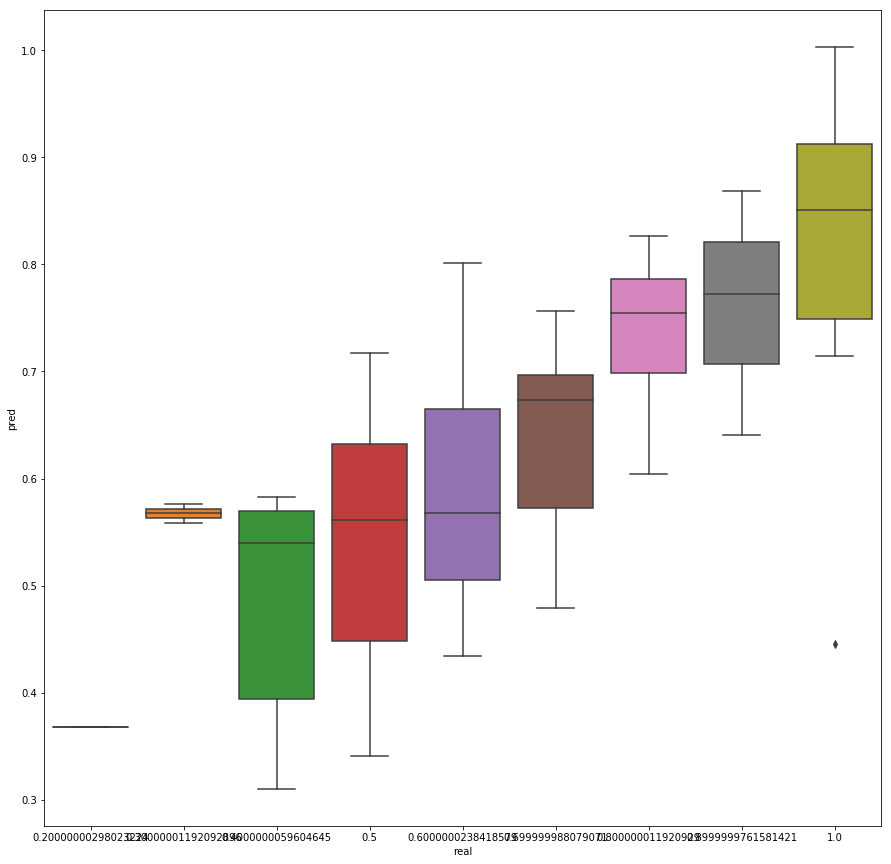

In [127]:
plt.figure(figsize=(15,15))
sns.categorical.boxplot(x="real", y="pred", data=pd_df)

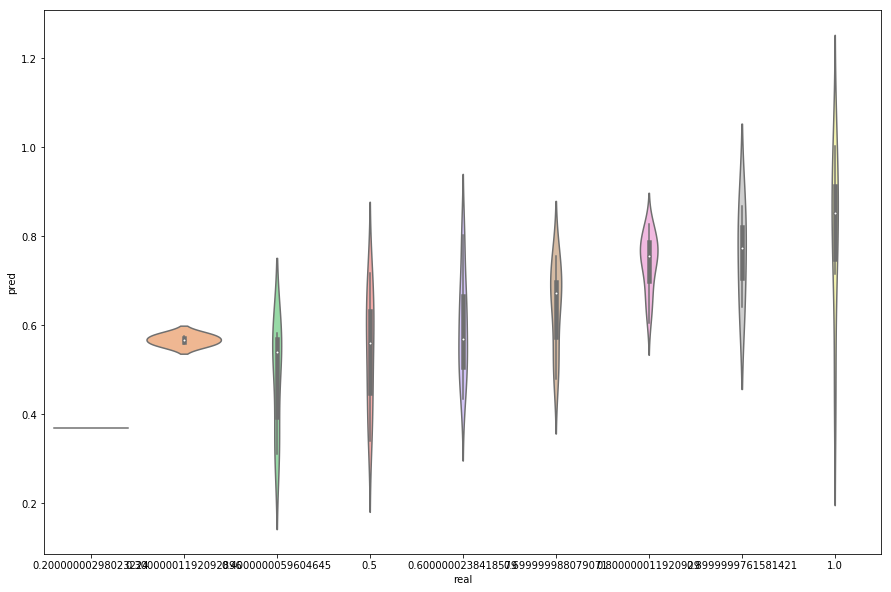

In [128]:
plt.figure(figsize=(15,10))
sns.categorical.violinplot(x="real", y="pred", split=True,  data=pd_df, palette="pastel")


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


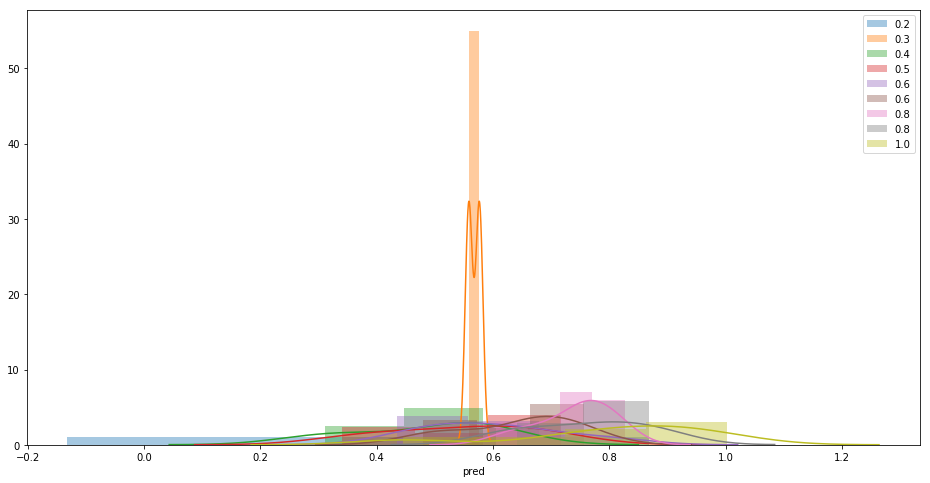

In [130]:
rs = list(pd_df['real'].unique())
rs.sort()
plt.figure(figsize=(16,8))
for r in rs:
    sns.distplot(pd_df['pred'][pd_df['real']==r], label=str(int(r*10)/10))
plt.legend()

In [0]:
genre_weight = CF.genres_layers[0].weight.detach().cpu().numpy().T

pca = decomposition.PCA(n_components = 5)
G_std = StandardScaler().fit_transform(genre_weight)
G_pca = pca.fit_transform(G_std)

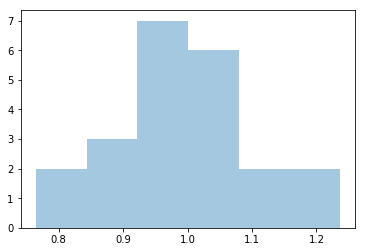

In [132]:
L = np.linalg.norm(genre_weight,axis=1,keepdims=True)
sns.distplot(L,kde=False)

(-4.58659, 5.8561897)

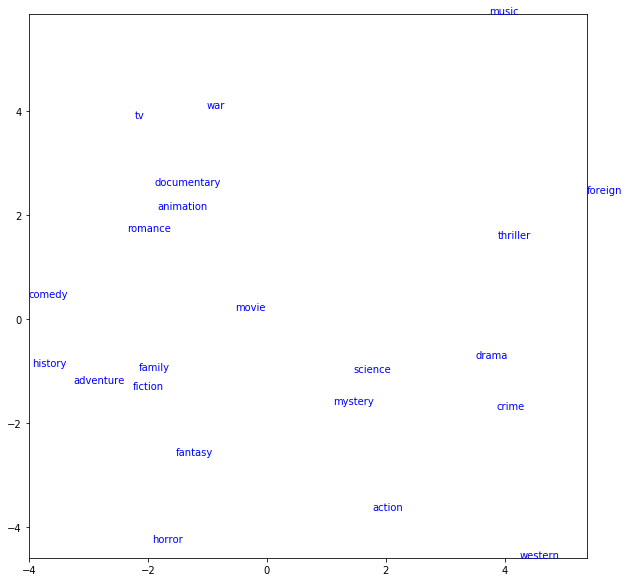

In [133]:
plt.figure(figsize=(10,10))

xs = []
ys = []

for key in genres_dict:
    i = genres_dict[key]
    x,y = G_pca[i,0], G_pca[i,1]
    xs+=[x]
    ys+=[y]
    plt.text(x,y,key,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = CF.movie_embedding.weight.data.detach().cpu().numpy()

In [0]:
L = np.linalg.norm(Movie_Em,axis=1,keepdims=True)

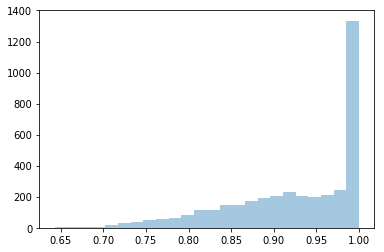

In [136]:
sns.distplot(L,kde=False)

In [0]:
pca = decomposition.PCA(n_components = 5)
M_std = StandardScaler().fit_transform(Movie_Em)
M_pca = pca.fit_transform(M_std)

(-6.215754308371138, 6.597556352280147, -4.6093565116894455, 5.567357115325395)

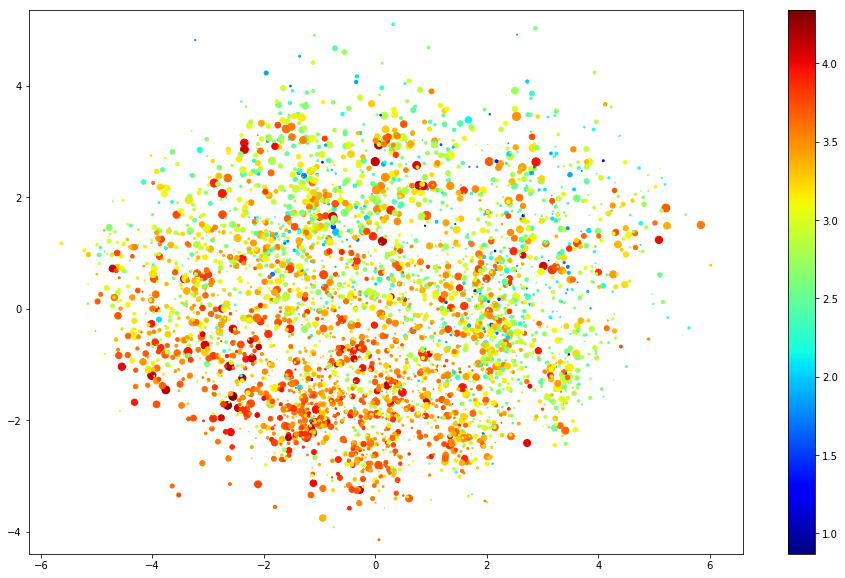

In [138]:
plt.figure(figsize=(16,10))

ss = (movie_df['num_rating'].values - movie_df['num_rating'].min())/60

plt.scatter(M_pca[:,0], M_pca[:,1], c = movie_df['movie_ave_rating'].values, s = ss, cmap='jet')
plt.colorbar()
plt.axis('equal')

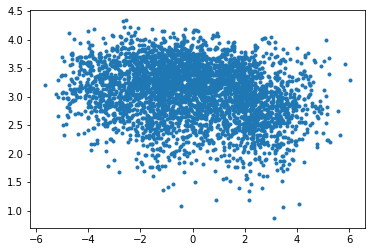

In [139]:
plt.plot(M_pca[:,0], movie_df['movie_ave_rating'],'.')

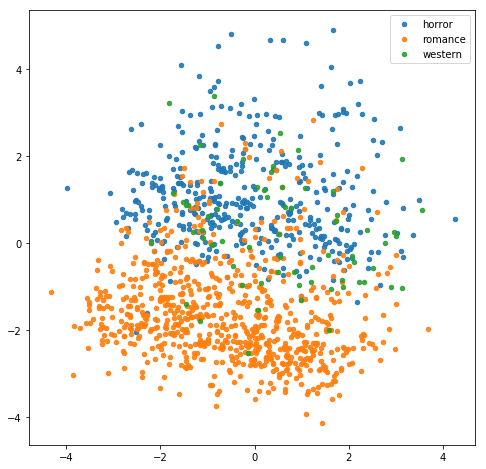

In [140]:
plt.figure(figsize=(8,8))
#for g in ML_Dataset.movie_genres:
for g in ['horror','romance','western']:
    i_g = genres_dict[g]
    ind = np.where(genres[:,i_g]==1)[0].tolist()
    plt.scatter(M_pca[ind,2], M_pca[ind,1],label=g,s=20, alpha=0.9)
plt.legend()

In [0]:
TopMovies_id = movie_df['num_rating'].nlargest(200).index.values

(-3.4031062, 3.911649)

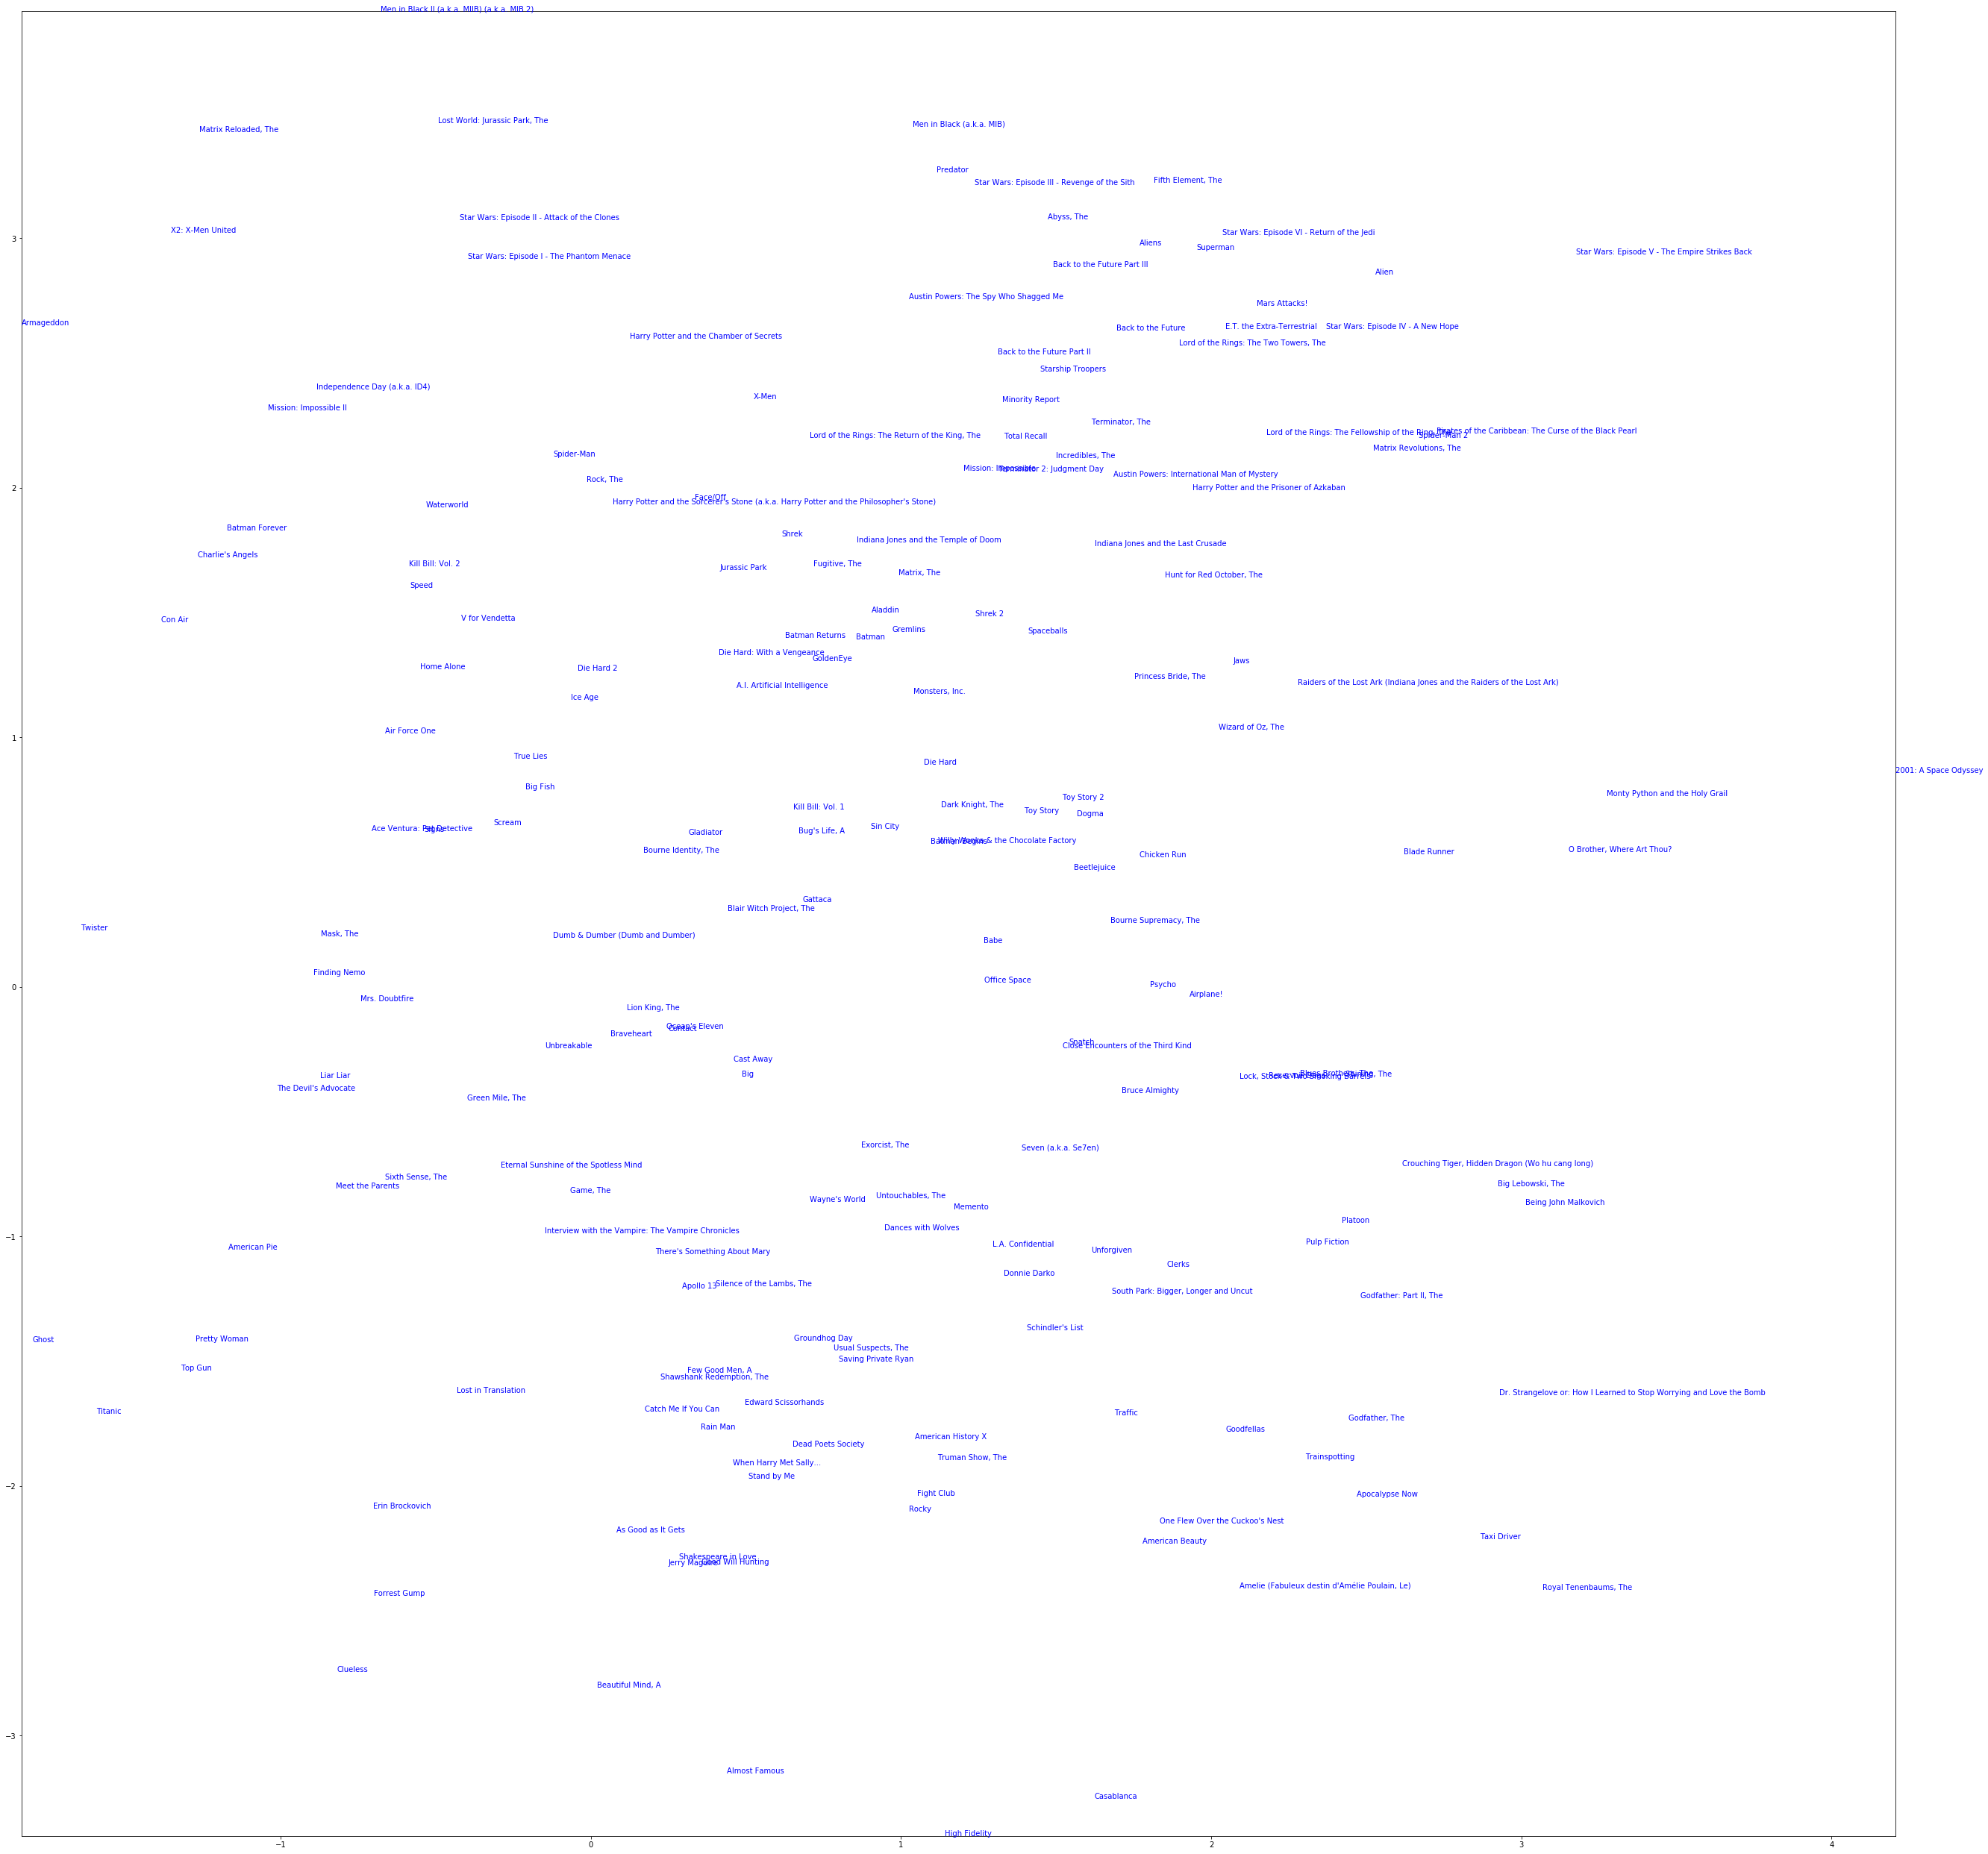

In [142]:
plt.figure(figsize=(45,45))
#plt.scatter(M_pca[:,0], M_pca[:,1])

xs = []
ys = []

for i in TopMovies_id:
    t = movie_df['title'][i]
    x,y = M_pca[i,2], M_pca[i,1]
    xs+=[x]
    ys+=[y]
    #if(x>xlim[0] and x<xlim[1] and y>ylim[0] and y<ylim[1]):
    plt.text(x,y,t,color='b', fontsize=10)

plt.xlim([min(xs),max(xs)])
plt.ylim([min(ys),max(ys)])

In [0]:
Movie_Em = Movie_Em/L

In [0]:
Movie_Em = Movie_Em/L
Movie_S = np.matmul(Movie_Em, Movie_Em.T)

In [145]:
Movie_Em = Movie_Em/L
Movie_S = np.matmul(Movie_Em, Movie_Em.T)
for i in range(50):
    movie_id = TopMovies_id[i]
    t = movie_df['title'][movie_id]
    print('Movie:'+t)
    
    tmp_S = Movie_S[movie_id]
    tmp_ids = tmp_S.argsort()[::-1]
    n = 0
    for tmp_id in tmp_ids[1:]:
        if(movie_df['movie_ave_rating'][tmp_id]>0.0):
            t = movie_df['title'][tmp_id]
            print('  ',t)
            n+=1
        if (n>10):
            break
    print()

Movie:Matrix, The
   Gladiator
   Star Wars: Episode IV - A New Hope
   Aeon Flux
   Total Recall
   Dark City
   Terminator 2: Judgment Day
   Star Wars: Episode VI - Return of the Jedi
   Living Daylights, The
   Abyss, The
   Indiana Jones and the Temple of Doom
   Star Wars: Episode V - The Empire Strikes Back

Movie:Forrest Gump
   Cast Away
   Schindler's List
   Flags of Our Fathers
   Rain Man
   Truman Show, The
   Dead Poets Society
   Saving Private Ryan
   Shawshank Redemption, The
   Philadelphia
   Gladiator
   Good Will Hunting

Movie:Back to the Future
   Indiana Jones and the Temple of Doom
   Beverly Hills Cop
   Bill & Ted's Excellent Adventure
   Back to the Future Part II
   Indiana Jones and the Last Crusade
   Big
   Star Wars: Episode IV - A New Hope
   Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark)
   Back to the Future Part III
   Pirates of the Caribbean: Dead Man's Chest
   Blazing Saddles

Movie:Pulp Fiction
   Seven (a.k.a. Se7en)


In [0]:
movie_embedding = CF.movie_embedding.weight.data.detach().cpu().numpy()
user_embedding = CF.user_embedding.weight.data.detach().cpu().numpy()

In [0]:
genres_weight = CF.genres_layers[0].weight.data.detach().cpu().numpy()
genres_bias = CF.genres_layers[0].bias.data.detach().cpu().numpy()

In [0]:
fc_relevance = [{},{},{}]
for ilayer in range(3):
    fc_relevance[ilayer]['weight'] = CF.fc_layers_relevance[ilayer*2].weight.data.detach().cpu().numpy()
    fc_relevance[ilayer]['bias'] = CF.fc_layers_relevance[ilayer*2].bias.data.detach().cpu().numpy()
    

In [0]:
kw_embedding_np = dict((k,v.detach().cpu().numpy()[0][0]) for (k,v) in kw_embedding.items())

In [150]:
kw_default_embedding.shape

torch.Size([1, 1, 64])

In [0]:
model_weights = {'genres_weight':genres_weight,
                'genres_bias':genres_bias,
                'genres_list': genres_list,
                'genres_dict': genres_dict,
                'movie_embedding': movie_embedding,
                'fc_relevance': fc_relevance,
                 'kw_embedding': kw_embedding_np,
                 'kw_default_embedding': kw_default_embedding[0][0].detach().numpy(),
                 'kw_set': kw_set                 
                }

In [0]:
def get_query_vector(query, model_weights):
    kws = [kw.lower() for kw in query.split(' ')]
    n = 0
    res = np.zeros(64)
    for kw in kws:
        if kw in model_weights['kw_set']:
            print(kw)
            res+=model_weights['kw_embedding'][kw]
            n+=1
    if n==0:
        return model_weights['kw_default_embedding']
    else:
        return res/n

In [0]:
def get_genre_vector(genres, model_weights):
    v = np.zeros((22,1))
    for g in genres:
        if g in model_weights['genres_dict']:
            v[model_weights['genres_dict'][g]]=1
    
    return model_weights['genres_weight'].dot(v).squeeze(1)+model_weights['genres_bias']

In [0]:
def predict(model_weights, query, user_embedding, genres):

    query_embedding = get_query_vector(query, model_weights)
    genres_embedding = get_genre_vector(genres_q, model_weights)

    final_query_em = ave_User_Em + genres_embedding + query_embedding

    relevance_em = np.concatenate((model_weights['movie_embedding'], genres_embedding.reshape(1,64).repeat(nM,axis=0), query_embedding.reshape(1,64).repeat(nM,axis=0)),axis=1)

    for i, fc in enumerate(model_weights['fc_relevance']):
        relevance_em = relevance_em.dot(fc['weight'].T)+fc['bias']
        if i<len(model_weights['fc_relevance'])-1:
            relevance_em = np.tanh(relevance_em)
        else:
            relevance_em = 1. / (1. + np.exp(-relevance_em))

    relevance_score = relevance_em.squeeze(axis=1)
    rating_score = final_query_em.dot(model_weights['movie_embedding'].T).squeeze(0)
    
    return relevance_score, rating_score

In [0]:
query = 'toy story'
genres_q = ['family','animation']

In [156]:
rel, rat = predict(model_weights, query, ave_User_Em, genres_q)

toy
story


In [0]:
ind_rel = np.argsort(rel)[::-1][:200]
ind = [ind_rel[i] for i in np.argsort(rat[ind_rel])[::-1]]

In [158]:
movie_df.iloc[list(ind)]

,index,Unnamed: 0,title,movieId,qmdbId,tmdbId,year,genre_kws,kws_all,num_rating,movie_ave_rating,movie_std_rating
3005,3005,3005,Cats & Dogs: The Revenge of Kitty Galore,8713,3006,39691,2010,"comedy,family",duringcreditsstinger kitty to the cats peyton ...,73,2.061644,1.127144
2906,2906,2906,"Secret of Kells, The",8530,2907,26963,2009,"fantasy,family,animation",animation woman for kells magic beautiful tomm...,272,3.439338,1.019639
1603,1603,1603,Bringing Down the House,4797,1604,10678,2003,comedy,shankman adam down house martin adam escape pr...,603,2.547264,0.909897
3329,3329,3329,Hit and Run (Hit & Run),9283,3330,109513,2012,"action,comedy,romance",dax duringcreditsstinger bell driver kristen a...,113,2.995575,0.846462
1943,1943,1943,"Polar Express, The",6187,1944,5255,2004,"fantasy,adventure,family,animation",robert leslie animation post bibliothek bell s...,1012,2.946146,1.035146
3119,3119,3119,Kung Fu Panda 2,8930,3120,49444,2011,"family,animation",animation woman much yuh jennifer panda black ...,797,3.227102,0.943035
3039,3039,3039,Tangled,8768,3040,38757,2010,"family,animation",runner byron selfishness mother animal chamele...,1198,3.500417,0.917094
3462,3462,3462,Monsters University,9531,3463,62211,2013,"family,animation",animation buscemi dan bd video billy college s...,903,3.329457,0.876356
503,503,503,"Children of Heaven, The (Bacheha-Ye Aseman)",1452,503,21334,1997,"comedy,family,drama",heaven naji majid bacheha ye foot realistic ma...,275,3.812727,1.061272
2038,2038,2038,Be Cool,6777,2039,4551,2005,"crime,comedy",gary don t be a travolta business care music s...,602,2.646179,0.921762
